In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.configs import MultiBandMelGANGeneratorConfig

from tensorflow_tts.models import TFMelGANGenerator
from tensorflow_tts.models import TFPQMF

In [2]:
with open('../examples/multiband_melgan/conf/multiband_melgan.v1.yaml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

In [3]:
config = MultiBandMelGANGeneratorConfig(**config["generator_params"])

In [4]:
class TFMBMelGANGenerator(TFMelGANGenerator):
    def __init__(self, config, **kwargs):
        super().__init__(config, **kwargs)
        self.pqmf = TFPQMF(config=config, name='pqmf')
        
    def build(self, input_shape):
        self.pqmf.build(input_shape)
        self.built = True
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, 80], dtype=tf.float32)])
    def call(self, mels):
        mb_audios = super().call(mels)
        audios = self.pqmf.synthesis(mb_audios)
        return audios

In [5]:
mb_melgan = TFMBMelGANGenerator(config, name="mb_melgan")

In [6]:
fake_mels = tf.random.uniform(shape=[4, 256, 80], dtype=tf.float32)

In [7]:
audios = mb_melgan(fake_mels)

In [8]:
mb_melgan.summary()

Model: "mb_melgan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      multiple                  2534356   
_________________________________________________________________
pqmf (TFPQMF)                multiple                  0         
Total params: 2,534,356
Trainable params: 2,534,356
Non-trainable params: 0
_________________________________________________________________


In [9]:
mb_melgan.load_weights("./generator-940000.h5", by_name=True)

# Save to Pb

In [10]:
tf.saved_model.save(mb_melgan, "./mb_melgan")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./mb_melgan/assets


# Load and Inference

In [11]:
mb_melgan = tf.saved_model.load("./mb_melgan")

In [12]:
mels = np.load("../dump/valid/norm-feats/LJ001-0009-norm-feats.npy")

In [13]:
audios = mb_melgan(mels[None, ...])

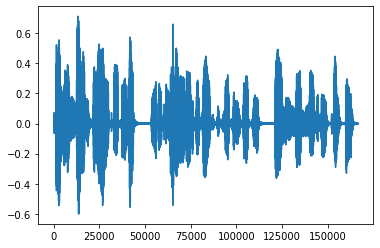

In [14]:
plt.plot(audios[0, :, 0])